# Build custom model 

This notebook walks through the process of preparing the dataset and the subsequently building a custom model in python for the MLOps certification. 

## Agenda
We'll do the following:
<br/>
1. Get a dataset suitable and prepare it for drift demonstration
2. Modify the dataset via
    - removing a subset of the data - YearMade of 2000 or older
    - randomly selecting from this subset, 20k for training and validation 
    - the rest of subset reserved as test set which we will we make submissions and feedback actuals
3. Build a RandomForest regressor model 
4. Pickle the pipeline 
5. TAR the assets submit to MLOps 

### Imports
First, we need to make the proper imports

In [5]:
# sklearn
import sklearn 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# others
import sys
import os
import math
import sklearn
import pandas as pd 
import numpy as np 
import pickle

from platform import python_version
print(python_version())
os.getcwd()

3.7.0


'/Users/eu.jin.lok/Documents/GIT-Projects/DataRobot_Workflows/MLOps_certification/development'

## 1. Get the dataset
We'll be using the fast iron 100k dataset that comes from the DRU course. This is ideal for a few reason, one being that it is a regression which is different, and secondly its very suitable for simulating a model degradation. But in order to do that, we'll need to do a few modifications 

First thing we're going to do is remove all models made in year 2000 and beyond. This will 'drift' our dataset which we will build up a story for data drift. 

In [6]:
# read data 
df = pd.read_csv(os.getcwd() + '/dataset/fast iron 100k data.csv', low_memory=False) # low_memory must be added to avoid error

# subset the data 
df = df.iloc[:,0:19]
df.drop(columns=['fiProductClassDesc'],inplace=True)
df = df.query("YearMade <= 2000")  

# munge 
for i in df.columns:
    if df[i].dtypes == 'int64':
        df[i].fillna(0, inplace=True)
    elif df[i].dtypes == 'float64':
        df[i].fillna(0, inplace=True)
    else:
        df[i].fillna('UNK', inplace=True)

print(df.shape)
df.head()

(83163, 18)


,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,state,ProductGroup
1,1139248,57000,117657,77,121,3,1996,4640.0,Low,3/26/2004 0:00,950FII,950,F,II,UNK,Medium,North Carolina,WL
6,1139256,21000,772701,1937,121,3,1993,11540.0,High,8/26/2004 0:00,790ELC,790,E,UNK,LC,Large / Medium,Florida,TEX
9,1139275,65000,1016474,3883,121,3,1000,20700.0,Medium,8/9/2007 0:00,988B,988,B,UNK,UNK,Large,Florida,WL
11,1139282,22500,319906,5255,121,3,1998,2764.0,Low,8/24/2006 0:00,D31E,D31,E,UNK,UNK,UNK,Ohio,TTT
12,1139283,36000,1052214,2232,121,3,1998,0.0,UNK,10/20/2005 0:00,PC200LC6,PC200,UNK,LC,6,Large / Medium,Ohio,TEX


## 2. Subset the data 

We will now split the dataset into multiple chunks: 
1. For Training 
2. For validation 
3. For subsequent scoring (test)

In [7]:
# pop out the target on its own
y = df.pop('SalePrice')

# Split training and test and save them 
X_train, X_test, y_train, y_test = train_test_split(df, y, train_size = 20000, random_state = 42)
X_test.to_csv(os.getcwd() + "/dataset/X_test.csv",index=False, header = True)
y_test.to_csv(os.getcwd() + "/dataset/Y_test.csv",index=False, header = True)

# From training set split futher to get validation set and save them 
X_train.pop('SalesID')
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size = 0.75, random_state = 42)
X_train.to_csv(os.getcwd() + "/dataset/X_train.csv",index=False, header = True)
y_train.to_csv(os.getcwd() + "/dataset/Y_train.csv",index=False, header = True)

print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_test.shape)
print(y_valid.shape)

(15000, 16)
(63163, 17)
(5000, 16)
(15000,)
(63163,)
(5000,)


## 3. Build the model 

Now that we have our dataset, we'll need to do some recoding and transformation, and we'll create a pipeline processsing for this, by using the sklearn 'pipeline'. That way it ensures we can score the data in its rawrest form and get it pre-process in accordance to our blueprint

In [8]:
# Split the feature types   
numeric_features = list(X_train.select_dtypes(include=np.number).columns.values)
categorical_features = list(set(X_train.columns) - set(numeric_features))

# Create pipeline for numericals 
numeric_preprocessing = Pipeline(
    [('Imputation', SimpleImputer(strategy='mean')), ('Scaling', StandardScaler())]
)

# Create pipeline for categorical 
categorical_preprocessing = Pipeline(
    [
        ('Imputation', SimpleImputer(strategy='constant', fill_value='UNK')),
        ('One Hot Encoding', OneHotEncoder(handle_unknown='ignore')),
    ]
)

# Build in the transformer 
preprocessing = make_column_transformer(
    (numeric_preprocessing, numeric_features),
    (categorical_preprocessing, categorical_features),
)

# Chain the pipelines 
pipeline = Pipeline(
    [('Preprocessing', preprocessing), ('Random Forest Regressor', RandomForestRegressor())]
)

# Now fit it to the training data 
pipeline.fit(X_train, y_train)

/Users/eu.jin.lok/Documents/GIT-Projects/data-science-scripts/eujinlok/MLOps-Demo-Certification/myenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('Preprocessing',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('Imputation',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='mean',
                                                    

##  Evaluate
To make sure we're doing things right, lets run through a quick evaluation check 

RMSE = 11252.026020677342


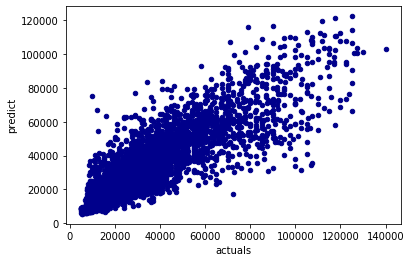

In [11]:
# predict test instances
y_preds = pipeline.predict(X_valid)
y_preds = pd.concat([y_valid.reset_index(drop=True),pd.DataFrame(y_preds)],axis=1)
y_preds.columns = ['actuals','predict']

# RMSE
print('RMSE = ' + str(math.sqrt(mean_squared_error(y_preds.actuals,y_preds.predict))))

# Plot 
ax1 = y_preds.plot.scatter(x='actuals',
                       y='predict',
                       c='DarkBlue')

## 4. Pickle the pipeline 
Now we make a pickle and deploy this custom model to MLOps

In [75]:
with open('custom_model.pickle', 'wb') as picklefile:
    pickle.dump(pipeline, picklefile)
    
# Save the train dataset with the target for MLOps
df = pd.concat([X_train, pd.DataFrame(y_train)], axis=1, sort=False)
df.to_csv(os.getcwd() + "/dataset/XY_train.csv",index=False, header = True)

## 5. TAR the assets and submit to MLOps

### IMPORTANT
When submitting first time the ###.Tar.gz files, gave this error:
```
Error testing model: Provided custom model and environment cannot be used together. Custom model archive does not contain start_server.sh in the archive root. Environment archive does not contain start_server.sh in the archive root
```
This is related to the custom_model_template where the server is not recognising that start_server.sh is an executable. So to fix that, go to the directory with the executable and run on command line:
```bash
chmod +x start_server.sh
```
Then TAR ball the directories again by going to the original Custom Model Tempates repo and run on command line
```bash
tar -czf python_model.tar.gz python_model
```